## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 2. Read the dataset

In [3]:
df=pd.read_csv("National Stock Exchange-Tata.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


## 3. Analyze the closing prices from dataframe

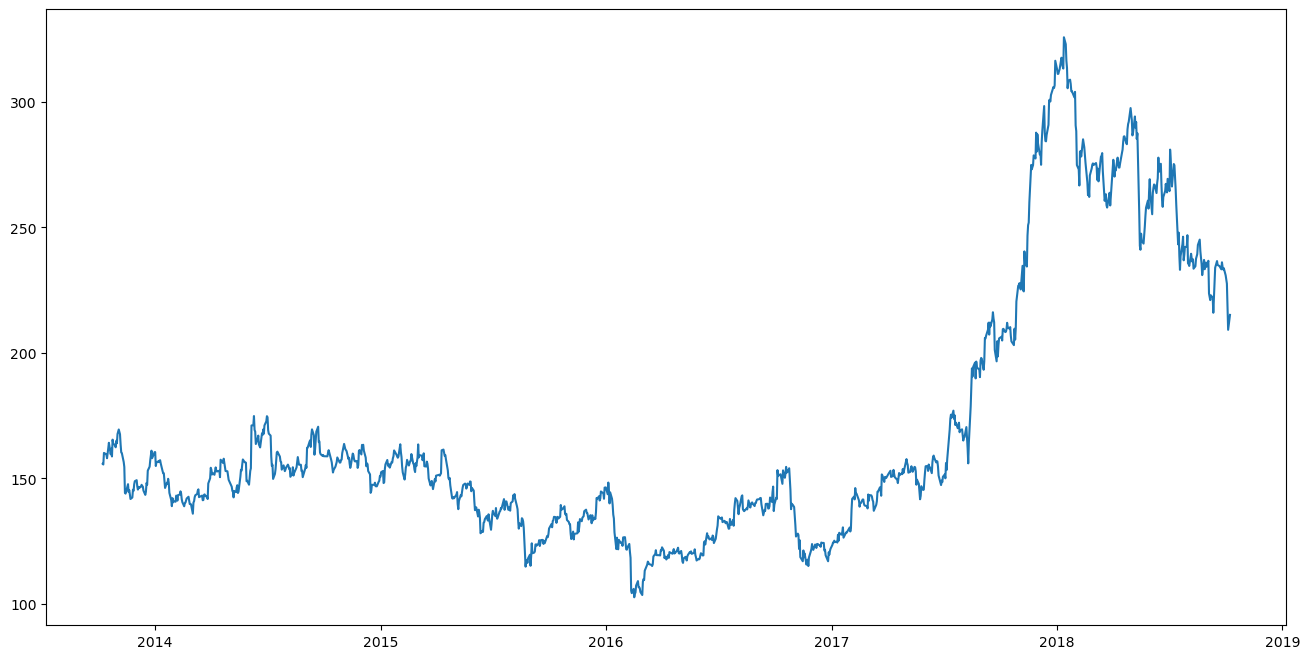

In [4]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

## 4. Sort the dataset on date time and filter “Date” and “Close” columns

In [5]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

## 5. Normalize the new filtered dataset

In [6]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values
train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(new_dataset.values)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

## 6. Build and train the LSTM model

In [7]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = lstm_model.fit(x_train_data, y_train_data, epochs=100, batch_size=1, verbose=2, validation_split=0.1)

Epoch 1/100
834/834 - 17s - loss: 7.1995e-04 - val_loss: 0.0023 - 17s/epoch - 20ms/step
Epoch 2/100
834/834 - 14s - loss: 3.8524e-04 - val_loss: 6.2417e-04 - 14s/epoch - 16ms/step
Epoch 3/100
834/834 - 15s - loss: 2.6107e-04 - val_loss: 8.0792e-04 - 15s/epoch - 17ms/step
Epoch 4/100
834/834 - 14s - loss: 2.3018e-04 - val_loss: 4.1692e-04 - 14s/epoch - 17ms/step
Epoch 5/100
834/834 - 15s - loss: 2.0264e-04 - val_loss: 4.6248e-04 - 15s/epoch - 17ms/step
Epoch 6/100
834/834 - 15s - loss: 2.0065e-04 - val_loss: 3.8320e-04 - 15s/epoch - 18ms/step
Epoch 7/100
834/834 - 16s - loss: 1.9111e-04 - val_loss: 3.8145e-04 - 16s/epoch - 19ms/step
Epoch 8/100
834/834 - 16s - loss: 1.9591e-04 - val_loss: 6.5059e-04 - 16s/epoch - 19ms/step
Epoch 9/100
834/834 - 17s - loss: 1.9945e-04 - val_loss: 5.4292e-04 - 17s/epoch - 20ms/step
Epoch 10/100
834/834 - 17s - loss: 1.9301e-04 - val_loss: 4.0944e-04 - 17s/epoch - 20ms/step
Epoch 11/100
834/834 - 16s - loss: 1.8879e-04 - val_loss: 3.6886e-04 - 16s/epoch - 

## 7. Take a sample of a dataset to make stock price predictions using the LSTM model

In [8]:
# Take a sample of the dataset to make stock price predictions using the LSTM model
inputs_data = new_dataset[len(new_dataset) - len(valid_data) - 60:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data  = scaler.transform(inputs_data)

X_test = []
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)


8/8 [==============================] - 1s 16ms/step


## 8. Save the LSTM model

In [9]:
lstm_model.save("saved_model.h5")

## 9. Visualize the predicted stock costs with actual stock costs

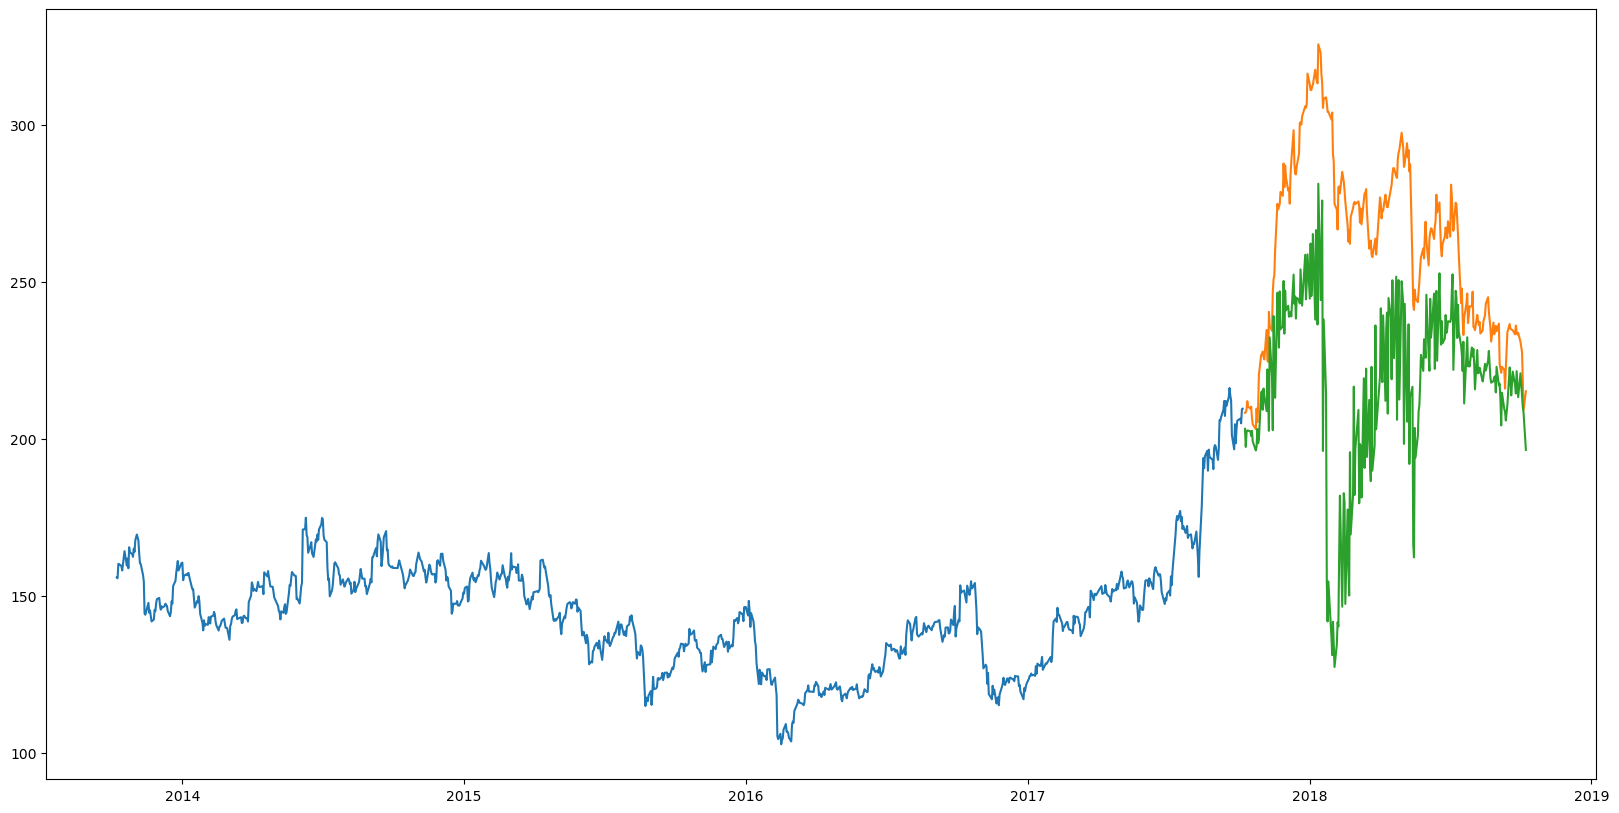

In [10]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])